In [23]:
import numpy as np
import cupy as cp
import os
from bioio import BioImage
import tifffile
import timeit
from matplotlib import pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d

seed = 363
rng = np.random.default_rng(seed)

In [67]:
parent_path = r'D:\images\tnia-python-images\tg\2024_10_22_ts_decon'
image_path = r'_small_data_\[AS-00304]\1x1_FOVs'
image_name = r'Slide 1 - A02 - ROI 01_1x1_FOVs - DAPI.tif'

full_name = os.path.join(parent_path, image_path, image_name)
bioimg = BioImage(full_name)

image = np.squeeze(bioimg.data)

print(f'dtype = {image.dtype}') 
print(f'min = {np.min(image)}')
print(f'max = {np.max(image)}')

# Add new z-axis if we have 2D data
if image.ndim == 2:
  image = np.expand_dims(image, axis=0)

print(image.shape)



dtype = uint8
min = 2
max = 255
(1, 995, 1334)


In [68]:
from tnia.deconvolution.gaussian_psf import gaussian_2d
sigma = 2.0
psf_temp = gaussian_2d(255,sigma)

# Add new z-axis if we have 2D data
if psf_temp.ndim == 2:
  psf_temp = np.expand_dims(psf_temp, axis=0)

# Pad to size of image
psf = np.zeros(image.shape)
psf[:psf_temp.shape[0], :psf_temp.shape[1], :psf_temp.shape[2]] = psf_temp
for axis, axis_size in enumerate(psf.shape):
  psf = np.roll(psf, int(axis_size / 2), axis=axis)
for axis, axis_size in enumerate(psf_temp.shape):
  psf = np.roll(psf, -int(axis_size / 2), axis=axis)
psf = np.fft.ifftshift(psf)
psf = psf / np.sum(psf)

In [79]:
from tnia.deconvolution.gaussian_psf import gaussian_2d
sigma = 2.0
psf_temp = gaussian_2d(255,sigma)

# Add new z-axis if we have 2D data
if psf_temp.ndim == 2:
  psf_temp = np.expand_dims(psf_temp, axis=0)

# Pad to size of image
psf = np.zeros(image.shape)
psf[:psf_temp.shape[0], :psf_temp.shape[1], :psf_temp.shape[2]] = psf_temp
for axis, axis_size in enumerate(psf.shape):
  psf = np.roll(psf, int(axis_size / 2), axis=axis)
for axis, axis_size in enumerate(psf_temp.shape):
  psf = np.roll(psf, -int(axis_size / 2), axis=axis)
psf = np.fft.ifftshift(psf)
psf = psf / np.sum(psf)

In [ ]:
def fftconv(x, H):
	return cp.real(cp.fft.ifftn(cp.fft.fftn(x) * H))


def kldiv(p, q, mask_val=0):

	p = p + 1E-4
	q = q + 1E-4
	p = p / cp.sum(p)
	q = q / cp.sum(q)

	# calculate MSE
	mse = (p - q) ** 2

	kldiv = p * (cp.log(p) - cp.log(q))
	kldiv[cp.isnan(kldiv)] = 0
	kldiv[p < mask_val] = 0
	kldiv = cp.sum(kldiv)
	return kldiv, mse

# Load data and PSF onto GPU
image = cp.array(image, dtype=cp.float32)
psf = cp.array(psf, dtype=cp.float32)

# Calculate OTF and transpose
otf = cp.fft.fftn(psf)
otfT = cp.conjugate(otf)
del psf

# Get dimensions of data
num_z = image.shape[0]
num_y = image.shape[1]
num_x = image.shape[2]
num_pixels = num_z * num_y * num_x

# Calculate Richardson-Lucy iterations
HTones = fftconv(cp.ones_like(image), otfT)
recon = cp.mean(image) * cp.ones((num_z, num_y, num_x), dtype=cp.float32)
previous_recon = recon

num_iters = 0
prev_kldim = np.inf
prev_kld1 = np.inf
prev_kld2 = np.inf

prev_kldim_map = cp.zeros((num_z, num_y, num_x), dtype=cp.float32)
prev_kld1_map = cp.zeros((num_z, num_y, num_x), dtype=cp.float32)
prev_kld2_map = cp.zeros((num_z, num_y, num_x), dtype=cp.float32)


split1 min = 0 split2 max = 151.0
prev_kldim: 0.0019473324064165354, prev_kld1: 0.0744619183544979, prev_kld2: 0.07372690040126972
kldim: 0.001842299709096551, kld1: 0.07434904258476964, kld2: 0.07363611890235311


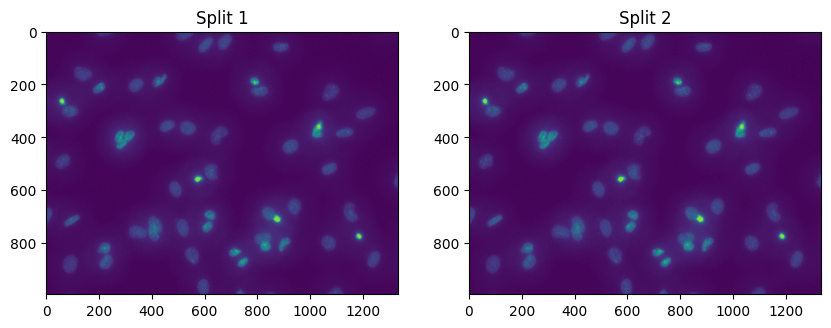

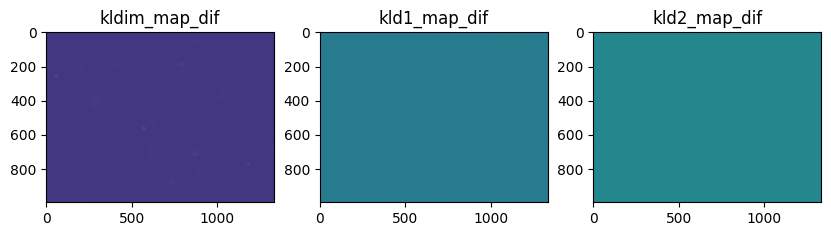

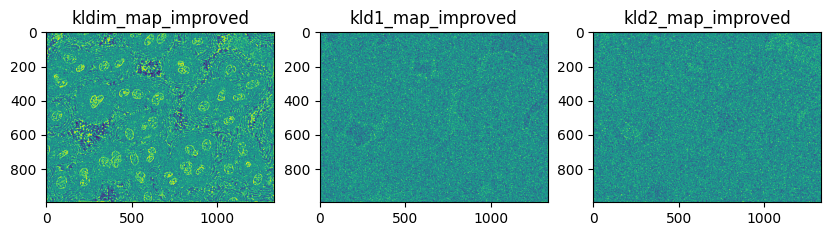

In [86]:
# Split recorded image into 50:50 images
# TODO: make this work on the GPU (for some reason, we get repeating blocks with a naive conversion to cupy)
split1 = rng.binomial(image.get().astype('int64'), p=0.5)
split1 = cp.array(split1)
split2 = image - split1

fig = imshow_multi2d([split1.get(), split2.get()], ['Split 1', 'Split 2'], 1, 2)

# Calculate prediction
Hu = fftconv(recon, otf)

# Calculate KL divergences and stop iterations if both have increased
kldim, kldim_map = kldiv(Hu, image)
kld1, kld1_map  = kldiv(Hu, split1)
kld2, kld2_map = kldiv(Hu, split2)

print(f'split1 min = {cp.min(split1)} split2 max = {cp.max(split2)}')
print(f'prev_kldim: {prev_kldim}, prev_kld1: {prev_kld1}, prev_kld2: {prev_kld2}')
print(f'kldim: {kldim}, kld1: {kld1}, kld2: {kld2}')

prev_kldim = kldim
prev_kld1 = kld1
prev_kld2 = kld2

kldim_map_dif = prev_kldim_map- kldim_map
kld1_map_dif = prev_kld1_map - kld1_map
kld2_map_dif = prev_kld2_map - kld2_map

kldim_map_improved = kldim_map_dif > 0
kld1_map_improved = kld1_map_dif > 0
kld2_map_improved = kld2_map_dif > 0

fig = imshow_multi2d([kldim_map_dif.get(), kld1_map_dif.get(), kld2_map_dif.get()], ['kldim_map_dif', 'kld1_map_dif', 'kld2_map_dif'], 1, 3)
fig = imshow_multi2d([kldim_map_improved.get(), kld1_map_improved.get(), kld2_map_improved.get()], ['kldim_map_improved', 'kld1_map_improved', 'kld2_map_improved'], 1, 3)

prev_kldim_map = kldim_map
prev_kld1_map = kld1_map
prev_kld2_map = kld2_map

# Calculate updates for split images and full images (H^T (d / Hu))
HTratio1 = fftconv(split1 / (0.5 * (Hu + 1E-12)), otfT) / HTones
del split1
HTratio2 = fftconv(split2 / (0.5 * (Hu + 1E-12)), otfT) / HTones
del split2
HTratio = fftconv(image / (Hu + 1E-12), otfT) / HTones
del Hu

# Normalise update steps by H^T(1) and only update pixels in full estimate where split updates agree in 'sign'
shouldNotUpdate = (HTratio1 - 1) * (HTratio2 - 1) < 0
del HTratio1
del HTratio2
HTratio[shouldNotUpdate] = 1
num_updated = num_pixels - cp.sum(shouldNotUpdate)
del shouldNotUpdate

# Save previous estimate in case KLDs increase after this iteration
previous_recon = recon

# Update estimate
recon = recon * HTratio
min_HTratio = cp.min(HTratio)
max_HTratio = cp.max(HTratio)
max_relative_delta = cp.max((recon - previous_recon) / cp.max(recon))
del HTratio

In [74]:
import napari
viewer = napari.Viewer()
viewer.add_image(kldim_map.get(), name='kldim_map')

<Image layer 'kldim_map' at 0x19b13a61420>

In [84]:
import napari
viewer = napari.Viewer()
viewer.add_image(image.get(), name='image')
viewer.add_image(kldim_map_dif.get(), name='kldim_map_dif')
viewer.add_image(kld1_map_dif.get(), name='kld1_map_dif')
viewer.add_image(kld2_map_dif.get(), name='kld2_map_dif')

<Image layer 'kld2_map_dif' at 0x19b1cf316f0>

In [15]:
for i in range(10):
    print(rng.binomial([10, 120, 8], p=0.5))

[ 5 46  6]
[ 4 64  3]
[ 6 54  3]
[ 6 50  1]
[ 7 60  4]
[ 3 57  5]
[ 5 60  5]
[ 4 60  6]
[ 5 59  5]
[ 5 60  1]
